# Evaluating Turbulence and Systematic Risk of Financial Markets

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from tqdm import tqdm

import yfinance as yf

## 1. Fetch data (returns of all assets over entire history)

### Historical data

In [217]:
class Assets:
    def __init__(self, assets=None):
        self.assets = assets
        self.turbulence = pd.Series([], dtype='float64')
        self.all_returns = pd.DataFrame()
        self.returns_now = pd.Series([], dtype='float64')
        self.now = ""
        self.returns_history = pd.DataFrame()

        if self.assets is not None and len(self.assets) > 0:
            self.fetch_returns()


    def fetch_returns(self, period='10y', interval='1wk'):
        # fetching log returns
        returns_dict = {}

        for asset in self.assets:
            # fetch closing values
            pair = f"{asset}USD=X"
            data = yf.Ticker(pair)
            history = data.history(period=period, interval=interval)
            closing_values = history.Close.loc[(history.Close != 0)]

            # compute log returns
            log_returns = (np.log(closing_values) - np.log(closing_values.shift(1))).shift(-1)
            log_returns.dropna(inplace=True)

            returns_dict.update({asset: log_returns})

        self.all_returns = pd.DataFrame(returns_dict)

        # split between current return and historical returns
        current = {}
        historical = {}

        for key in self.assets:
            current.update({
                key: self.all_returns[key][-1]
            })

            historical.update({
                key: self.all_returns[key][:-1]
            })

        self.returns_history = pd.DataFrame(historical)
        self.returns_now = pd.Series(current)
        self.now = self.all_returns.index[-1]

        return True


    def plot_returns(self, shape=(3, 2)):
        x, y = shape
        fig, ax = plt.subplots(x, y, figsize=(15, 13))

        if x == y == 1:
            key = self.assets[0]
            ax.plot(self.all_returns[key], linewidth=0.4)
            ax.set(title=f'Logarithmic Returns for {key}/USD', xlabel=r'Closing time $t$', ylabel=r'Log-return $r$')
        elif (y == 1 and x > 1) or (x == 1 and y > 1):
            for i in range(x * y):
                key = self.assets[j]
                ax[i].plot(self.all_returns[key], linewidth=0.4)
                ax[i].set(title=f'Logarithmic Returns for {key}/USD', xlabel=r'Closing time $t$', ylabel=r'Log-return $r$')
        else:
            for j in  range(y):
                for i in range(x):
                    key = self.assets[x * j + i]
                    ax[i, j].plot(self.all_returns[key], linewidth=0.4)
                    ax[i, j].set(title=f'Logarithmic Returns for {key}/USD', xlabel=r'Closing time $t$', ylabel=r'Log-return $r$')
            
        plt.tight_layout()
        plt.show()


    def compute_returns_window(self, rets, window_size=250):
        window  = {}
        
        for key in self.assets:
            window.update({
                key: rets[key][-window_size:]
            })

        return pd.DataFrame(window)


    def compute_turbulence(self):
        # Covariance matrix computed over a moving 250-week window.
        returns_history_window = self.compute_returns_window(self.returns_history, window_size=250)
        inv_cov_matrix = np.linalg.pinv(returns_history_window.cov())
        returns_history_mean = self.returns_history.mean()

        # d_m = ((u - v) V^-1 (u - v)^T)^0.5
        raw_turbulence = np.square(
            mahalanobis(self.returns_now, returns_history_mean, inv_cov_matrix)
        )

        if self.now not in self.turbulence.index:
            self.turbulence = self.turbulence.append(pd.Series([raw_turbulence], index=[self.now]))
        else:
            self.turbulence[self.now] = raw_turbulence
        
        return raw_turbulence


    def gen_turbulence_sequence(self, window_size=250):
        initial_rets_seq = self.all_returns[:250]

        for i in range(250, len(self.all_returns)):
            current = self.all_returns[i]
            history = self.all_returns[:i]

            


#### US Dollar Index
USDX proportions:
- EUR = 57.6\%
- JPY = 13.6\%
- GBP = 11.9\%
- CAD = 9.1\%
- SEK = 4.2\%
- CHF = 3.6\%

/Users/tom/opt/miniconda3/envs/ThesisEnv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


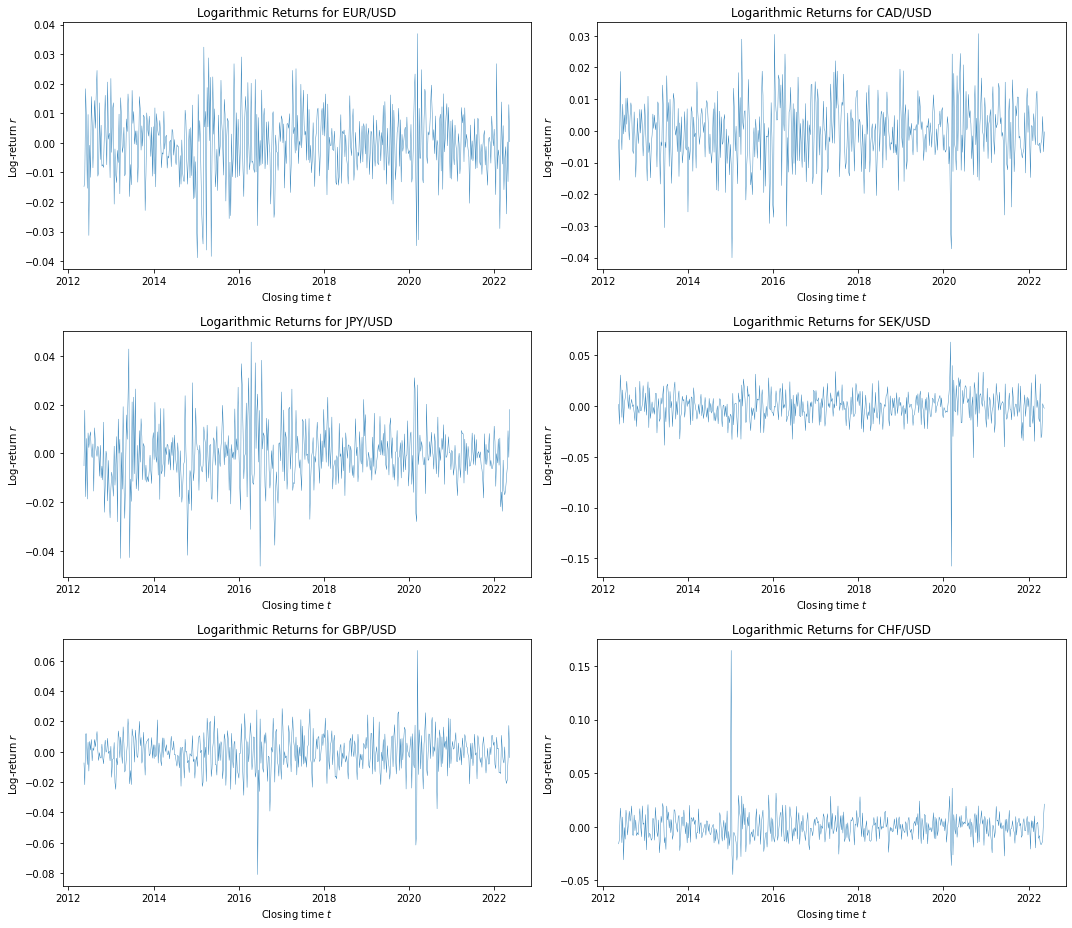

In [218]:
usdx_assets = [
    'EUR',
    'JPY',
    'GBP',
    'CAD',
    'SEK',
    'CHF',
]

usdx = Assets(usdx_assets)
usdx.plot_returns()

In [219]:
usdx.compute_turbulence()
usdx.turbulence

2022-05-16    11.75482
dtype: float64

#### Australian Dollar

/Users/tom/opt/miniconda3/envs/ThesisEnv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


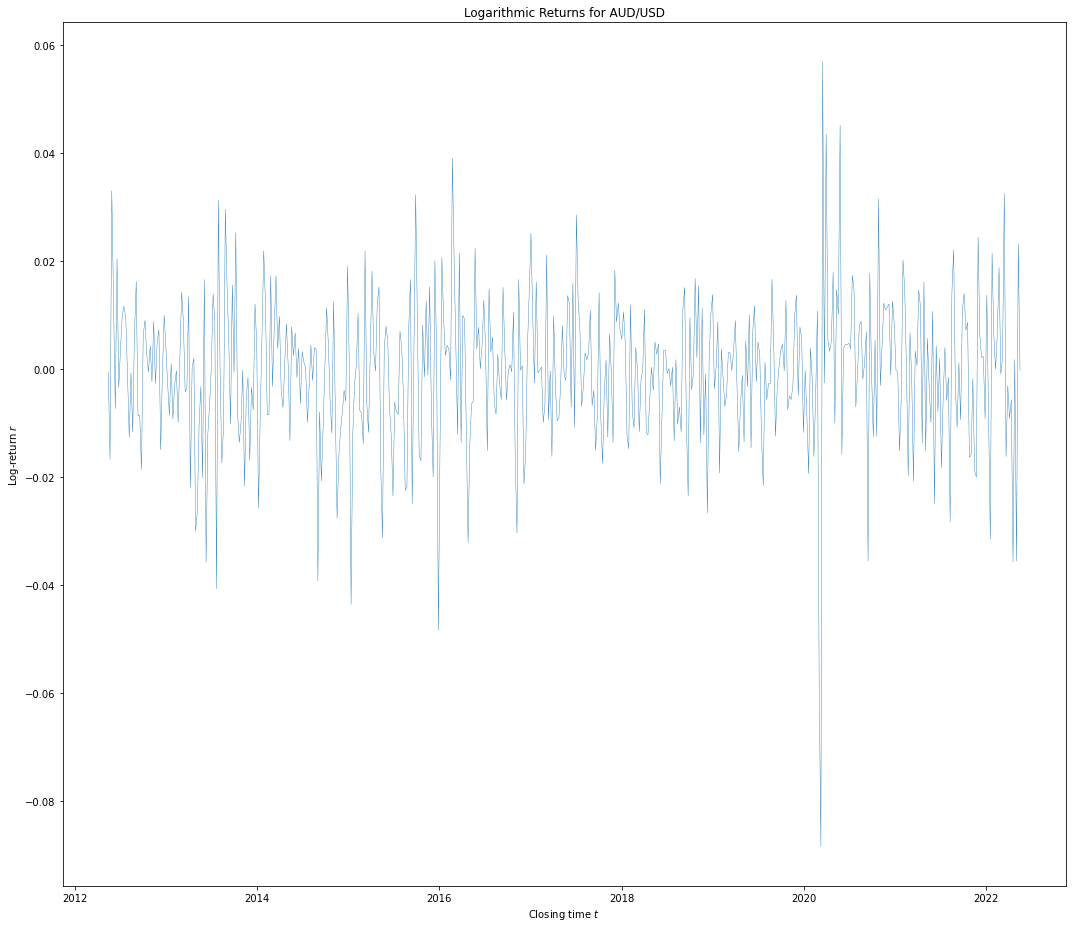

,AUD
Date,
2012-05-14,-0.000590
2012-05-21,-0.016755
2012-05-28,0.032996
2012-06-04,0.012761
2012-06-11,-0.007395
...,...
2022-04-18,-0.035767
2022-04-25,0.001710
2022-05-02,-0.035607


In [221]:
aud_assets = [
    'AUD'
]

aud = Assets(aud_assets)
aud.plot_returns(shape=(1,1))
aud.all_returns

In [ ]:
usdx.all_returns